In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6799773869821835 	 Validation loss: 0.6808013037099676 	 
  1%|          | 574/57400 [00:05<08:38, 109.66it/s]
Epoch 2 	 Training loss: 0.6687342195353027 	 Validation loss: 0.6578588435205363 	 
  2%|▏         | 1148/57400 [00:11<08:22, 112.05it/s]
Epoch 3 	 Training loss: 0.6541470086740699 	 Validation loss: 0.6475675904144675 	 
  3%|▎         | 1722/57400 [00:17<08:20, 111.32it/s]
Epoch 4 	 Training loss: 0.6451080226524366 	 Validation loss: 0.6399323889764689 	 
  4%|▍         | 2296/57400 [00:22<08:08, 112.83it/s]
Epoch 5 	 Training loss: 0.6368796567883641 	 Validation loss: 0.6308717343766811 	 
  5%|▌         | 2870/57400 [00:28<08:10, 111.25it/s]
Epoch 6 	 Training loss: 0.6290369522903855 	 Validation loss: 0.6242492683863236 	 
  6%|▌         | 3444/57400 [00:33<07:58, 112.84it/s]
Epoch 7 	 Training loss: 0.6211654461842381 	 Validation loss: 0.6171941464230165 	 
  7%|▋         | 4018/57400 [00:39<07:50, 113.38it/s]
Epoch 8 	 Training loss: 0.6

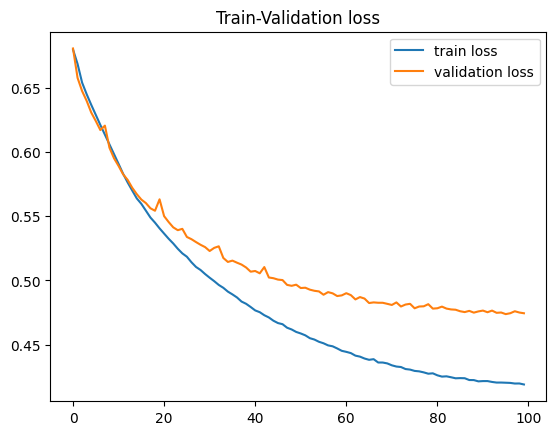

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7117346938775511, 'precision': 0.7117346938775511, 'f1': 0.7117346938775511, 'accuracy': 0.7117346938775511}
MALE {'recall': 0.8307291666666666, 'precision': 0.8307291666666666, 'f1': 0.8307291666666666, 'accuracy': 0.8307291666666666}
FEMALE {'recall': 0.5975, 'precision': 0.5975, 'f1': 0.5975, 'accuracy': 0.5975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5795454545454546, 'precision': 0.5795454545454546, 'f1': 0.5795454545454546, 'accuracy': 0.5795454545454546}
MALE {'recall': 0.6958637469586375, 'precision': 0.6958637469586375, 'f1': 0.6958637469586375, 'accuracy': 0.6958637469586375}
FEMALE {'recall': 0.4540682414698163, 'precision': 0.4540682414698163, 'f1': 0.4540682414698162, 'accuracy': 0.4540682414698163} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5853976531942634, 'precision': 0.5853976531942634, 'f1': 0.5853976531942634, 'accuracy': 0.5853976531942634}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6798178719726589 	 Validation loss: 0.6776579679068873 	 
  1%|          | 574/57400 [00:05<08:46, 107.88it/s]
Epoch 2 	 Training loss: 0.6655779973139746 	 Validation loss: 0.6570891879372678 	 
  2%|▏         | 1148/57400 [00:11<08:55, 105.11it/s]
Epoch 3 	 Training loss: 0.6546351037374357 	 Validation loss: 0.651409868466652 	 
  3%|▎         | 1722/57400 [00:17<08:51, 104.74it/s]
Epoch 4 	 Training loss: 0.6480899535197414 	 Validation loss: 0.6427060052499933 	 
  4%|▍         | 2296/57400 [00:23<08:39, 106.09it/s]
Epoch 5 	 Training loss: 0.6417643261703465 	 Validation loss: 0.6377848538301759 	 
  5%|▌         | 2870/57400 [00:29<08:47, 103.43it/s]
Epoch 6 	 Training loss: 0.6348004951709654 	 Validation loss: 0.6292631323054686 	 
  6%|▌         | 3444/57400 [00:35<08:42, 103.32it/s]
Epoch 7 	 Training loss: 0.6279915425835586 	 Validation loss: 0.6227738867371769 	 
  7%|▋         | 4018/57400 [00:41<08:26, 105.29it/s]
Epoch 8 	 Training loss: 0.62

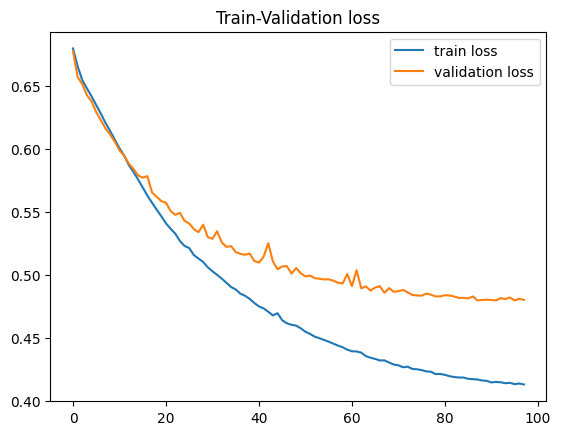

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7257653061224489, 'precision': 0.7257653061224489, 'f1': 0.725765306122449, 'accuracy': 0.7257653061224489}
MALE {'recall': 0.8385416666666666, 'precision': 0.8385416666666666, 'f1': 0.8385416666666666, 'accuracy': 0.8385416666666666}
FEMALE {'recall': 0.6175, 'precision': 0.6175, 'f1': 0.6175, 'accuracy': 0.6175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5972222222222222, 'precision': 0.5972222222222222, 'f1': 0.5972222222222222, 'accuracy': 0.5972222222222222}
MALE {'recall': 0.7201946472019465, 'precision': 0.7201946472019465, 'f1': 0.7201946472019465, 'accuracy': 0.7201946472019465}
FEMALE {'recall': 0.4645669291338583, 'precision': 0.4645669291338583, 'f1': 0.4645669291338582, 'accuracy': 0.4645669291338583} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.621903520208605, 'precision': 0.621903520208605, 'f1': 0.621903520208605, 'accuracy': 0.621903520208605}
MALE {'recall': 0.722

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6801480342494486 	 Validation loss: 0.6792984534118135 	 
  1%|          | 574/57400 [00:05<08:36, 110.01it/s]
Epoch 2 	 Training loss: 0.6641424287902353 	 Validation loss: 0.6549246048523207 	 
  2%|▏         | 1148/57400 [00:11<08:35, 109.10it/s]
Epoch 3 	 Training loss: 0.6514103965061467 	 Validation loss: 0.6473996305869798 	 
  3%|▎         | 1722/57400 [00:17<08:39, 107.25it/s]
Epoch 4 	 Training loss: 0.6439735435650323 	 Validation loss: 0.6400549280441413 	 
  4%|▍         | 2296/57400 [00:22<08:30, 108.05it/s]
Epoch 5 	 Training loss: 0.6373539011445195 	 Validation loss: 0.6339062775595713 	 
  5%|▌         | 2870/57400 [00:28<08:20, 109.02it/s]
Epoch 6 	 Training loss: 0.6305453673472388 	 Validation loss: 0.6270957599251957 	 
  6%|▌         | 3444/57400 [00:34<08:12, 109.53it/s]
Epoch 7 	 Training loss: 0.6236673187503416 	 Validation loss: 0.6209615984205472 	 
  7%|▋         | 4018/57400 [00:40<08:10, 108.93it/s]
Epoch 8 	 Training loss: 0.6

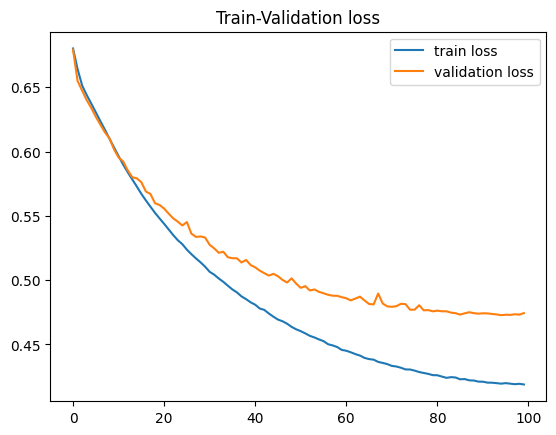

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7028061224489796, 'precision': 0.7028061224489796, 'f1': 0.7028061224489796, 'accuracy': 0.7028061224489796}
MALE {'recall': 0.7760416666666666, 'precision': 0.7760416666666666, 'f1': 0.7760416666666666, 'accuracy': 0.7760416666666666}
FEMALE {'recall': 0.6325, 'precision': 0.6325, 'f1': 0.6325, 'accuracy': 0.6325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5643939393939394, 'precision': 0.5643939393939394, 'f1': 0.5643939393939394, 'accuracy': 0.5643939393939394}
MALE {'recall': 0.6399026763990268, 'precision': 0.6399026763990268, 'f1': 0.6399026763990268, 'accuracy': 0.6399026763990268}
FEMALE {'recall': 0.48293963254593175, 'precision': 0.48293963254593175, 'f1': 0.48293963254593175, 'accuracy': 0.48293963254593175} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5658409387222947, 'precision': 0.5658409387222947, 'f1': 0.5658409387222947, 'accuracy': 0.5658409387222947}
MALE {'recal

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7134353741496599, 'precision': 0.7134353741496599, 'f1': 0.7134353741496599, 'accuracy': 0.7134353741496599}
Métricas etiqueta male: {'recall': 0.8151041666666666, 'precision': 0.8151041666666666, 'f1': 0.8151041666666666, 'accuracy': 0.8151041666666666}
Métricas etiqueta female:  {'recall': 0.6158333333333333, 'precision': 0.6158333333333333, 'f1': 0.6158333333333333, 'accuracy': 0.6158333333333333}

 to
Resultado global: {'recall': 0.5803872053872055, 'precision': 0.5803872053872055, 'f1': 0.5803872053872055, 'accuracy': 0.5803872053872055}
Métricas etiqueta male: {'recall': 0.6853203568532036, 'precision': 0.6853203568532036, 'f1': 0.6853203568532036, 'accuracy': 0.6853203568532036}
Métricas etiqueta female:  {'recall': 0.4671916010498688, 'precision': 0.4671916010498688, 'f1': 0.46719160104986873, 'accuracy': 0.4671916010498688}

 as
Resultado global: {'recall': 0.5910473707083876, 'precision': 0.5910473707083876, 'f1': 0.

## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955452788789929 	 Validation loss: 0.6990389732991235 	 
  1%|          | 574/57400 [00:05<08:30, 111.27it/s]
Epoch 2 	 Training loss: 0.6957953963753238 	 Validation loss: 0.6999154343443402 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:21, 112.18it/s]
Epoch 3 	 Training loss: 0.695705615165757 	 Validation loss: 0.6996433633868977 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:16<08:12, 113.12it/s]
Epoch 4 	 Training loss: 0.695494357613321 	 Validation loss: 0.6983865216626959 	 
  4%|▍         | 2296/57400 [00:22<08:26, 108.83it/s]
Epoch 5 	 Training loss: 0.6955362706857275 	 Validation loss: 0.699198081331738 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:03, 112.78it/s]
Epoch 6 	 Training loss: 0.6954303522973941 	 Validation loss: 0.6990925679772587 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:02, 111.84it/s]
Epoch 7 	 Training loss: 0.6953410631895897 	 Validati

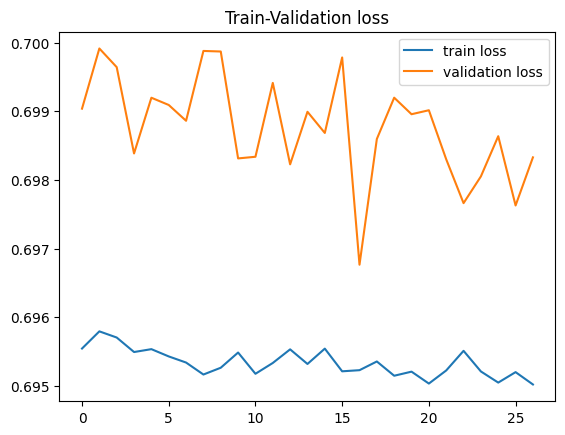

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934673320956346 	 Validation loss: 0.6947236737962497 	 
  1%|          | 574/57400 [00:05<08:32, 110.87it/s]
Epoch 2 	 Training loss: 0.6935267100558463 	 Validation loss: 0.694518357010211 	 
  2%|▏         | 1148/57400 [00:11<08:18, 112.90it/s]
Epoch 3 	 Training loss: 0.6934526004026991 	 Validation loss: 0.6945056006059809 	 
  3%|▎         | 1722/57400 [00:17<08:25, 110.15it/s]
Epoch 4 	 Training loss: 0.6934068817710212 	 Validation loss: 0.6947470206325337 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:07, 113.14it/s]
Epoch 5 	 Training loss: 0.6934571097952148 	 Validation loss: 0.6944868190813873 	 
  5%|▌         | 2870/57400 [00:28<08:04, 112.52it/s]
Epoch 6 	 Training loss: 0.6934737831042619 	 Validation loss: 0.6941152356438718 	 
  6%|▌         | 3444/57400 [00:33<08:14, 109.22it/s]
Epoch 7 	 Training loss: 0.6935234887051666 	 Validation loss: 0.694359965243582 	 

1 epoch without improvement
  7%|▋         | 4018/5740

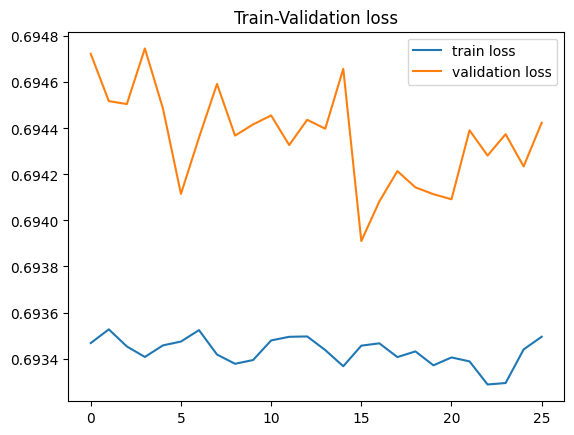

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49362244897959184, 'precision': 0.49362244897959184, 'f1': 0.49362244897959184, 'accuracy': 0.49362244897959184}
MALE {'recall': 0.9765625, 'precision': 0.9765625, 'f1': 0.9765625, 'accuracy': 0.9765625}
FEMALE {'recall': 0.03, 'precision': 0.03, 'f1': 0.03, 'accuracy': 0.03} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5151515151515151, 'precision': 0.5151515151515151, 'f1': 0.5151515151515151, 'accuracy': 0.5151515151515151}
MALE {'recall': 0.975669099756691, 'precision': 0.975669099756691, 'f1': 0.975669099756691, 'accuracy': 0.975669099756691}
FEMALE {'recall': 0.01837270341207349, 'precision': 0.01837270341207349, 'f1': 0.01837270341207349, 'accuracy': 0.01837270341207349} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5123859191655802, 'precision': 0.5123859191655802, 'f1': 0.5123859191655802, 'accuracy': 0.5123859191655802}
MALE {'recall': 0.9393939393939394, 'precision': 0.93939

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693274425712612 	 Validation loss: 0.6924429495455855 	 
  1%|          | 574/57400 [00:05<08:28, 111.70it/s]
Epoch 2 	 Training loss: 0.6932666662055026 	 Validation loss: 0.6922565062167281 	 
  2%|▏         | 1148/57400 [00:11<08:28, 110.55it/s]
Epoch 3 	 Training loss: 0.6932376155869886 	 Validation loss: 0.6923273741188696 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:23, 110.51it/s]
Epoch 4 	 Training loss: 0.6931723394668061 	 Validation loss: 0.692070092185069 	 
  4%|▍         | 2296/57400 [00:22<08:12, 111.78it/s]
Epoch 5 	 Training loss: 0.6932332689130764 	 Validation loss: 0.6922194038407278 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:22, 108.62it/s]
Epoch 6 	 Training loss: 0.6931848274706133 	 Validation loss: 0.6923966397673397 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:11, 109.77it/s]
Epoch 7 	 Training loss: 0.6932415735846197 	 Validation loss: 0.6924767878095982 

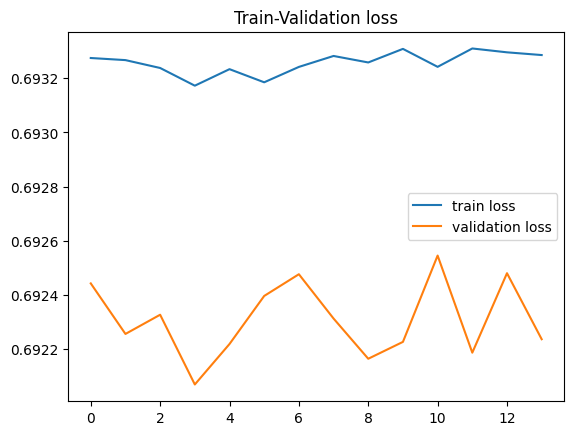

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5038265306122449, 'precision': 0.5038265306122449, 'f1': 0.5038265306122449, 'accuracy': 0.5038265306122449}
MALE {'recall': 0.028645833333333332, 'precision': 0.028645833333333332, 'f1': 0.028645833333333332, 'accuracy': 0.028645833333333332}
FEMALE {'recall': 0.96, 'precision': 0.96, 'f1': 0.96, 'accuracy': 0.96} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48737373737373735, 'precision': 0.48737373737373735, 'f1': 0.48737373737373735, 'accuracy': 0.48737373737373735}
MALE {'recall': 0.029197080291970802, 'precision': 0.029197080291970802, 'f1': 0.029197080291970802, 'accuracy': 0.029197080291970802}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4771838331160365, 'precision': 0.4771838331160365, 'f1': 0.4771838331160365, 'accuracy': 0.4771838331160365}
MALE

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4957482993197279, 'precision': 0.4957482993197279, 'f1': 0.4957482993197279, 'accuracy': 0.4957482993197279}
Métricas etiqueta male: {'recall': 0.6684027777777778, 'precision': 0.6684027777777778, 'f1': 0.6684027777777778, 'accuracy': 0.6684027777777778}
Métricas etiqueta female:  {'recall': 0.32999999999999996, 'precision': 0.32999999999999996, 'f1': 0.32999999999999996, 'accuracy': 0.32999999999999996}

 to
Resultado global: {'recall': 0.5071548821548821, 'precision': 0.5071548821548821, 'f1': 0.5071548821548821, 'accuracy': 0.5071548821548821}
Métricas etiqueta male: {'recall': 0.6682887266828873, 'precision': 0.6682887266828873, 'f1': 0.6682887266828873, 'accuracy': 0.6682887266828873}
Métricas etiqueta female:  {'recall': 0.3333333333333333, 'precision': 0.3333333333333333, 'f1': 0.3333333333333333, 'accuracy': 0.3333333333333333}

 as
Resultado global: {'recall': 0.5019556714471969, 'precision': 0.5019556714471969, 'f1':

# AS

In [31]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693329352431181 	 Validation loss: 0.6936692140870175 	 
  1%|          | 574/57400 [00:06<09:52, 95.89it/s]
Epoch 2 	 Training loss: 0.6931492372672317 	 Validation loss: 0.6944997078281337 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:33, 98.02it/s]
Epoch 3 	 Training loss: 0.6931198573693996 	 Validation loss: 0.6928219411332729 	 
  3%|▎         | 1722/57400 [00:19<09:23, 98.87it/s]
Epoch 4 	 Training loss: 0.6930214091875827 	 Validation loss: 0.6914539539207847 	 
  4%|▍         | 2296/57400 [00:25<09:15, 99.27it/s]
Epoch 5 	 Training loss: 0.6929580849637553 	 Validation loss: 0.692442065578396 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:10, 99.12it/s]
Epoch 6 	 Training loss: 0.6931029129319075 	 Validation loss: 0.6931780071581825 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:11, 97.82it/s]
Epoch 7 	 Training loss: 0.6929764334333067 	 Validation loss: 0.6924898917392149 	 

3 

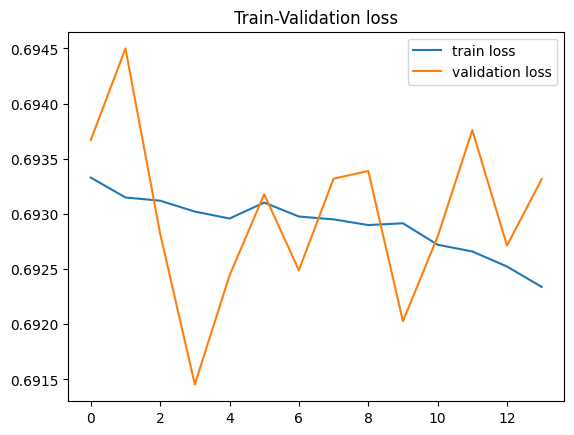

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.020833333333333332, 'precision': 0.020833333333333332, 'f1': 0.020833333333333332, 'accuracy': 0.020833333333333332}
FEMALE {'recall': 0.9775, 'precision': 0.9775, 'f1': 0.9775, 'accuracy': 0.9775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.012165450121654502, 'precision': 0.012165450121654502, 'f1': 0.012165450121654502, 'accuracy': 0.012165450121654502}
FEMALE {'recall': 0.984251968503937, 'precision': 0.984251968503937, 'f1': 0.984251968503937, 'accuracy': 0.984251968503937} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933086056534837 	 Validation loss: 0.692941511081437 	 
  1%|          | 574/57400 [00:06<09:39, 98.08it/s]
Epoch 2 	 Training loss: 0.6931925222848766 	 Validation loss: 0.6935347520698936 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:37, 97.45it/s]
Epoch 3 	 Training loss: 0.693204979447953 	 Validation loss: 0.6932609485367597 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:24, 98.71it/s]
Epoch 4 	 Training loss: 0.693133564464722 	 Validation loss: 0.692521809521368 	 
  4%|▍         | 2296/57400 [00:25<09:23, 97.74it/s]
Epoch 5 	 Training loss: 0.69302515399996 	 Validation loss: 0.6925571601269609 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:20, 97.29it/s]
Epoch 6 	 Training loss: 0.6930436947827555 	 Validation loss: 0.693955809383069 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:22, 95.94it/s]
Epoch 7 	 Training loss: 0.6929559213359181 	 Validation loss: 0

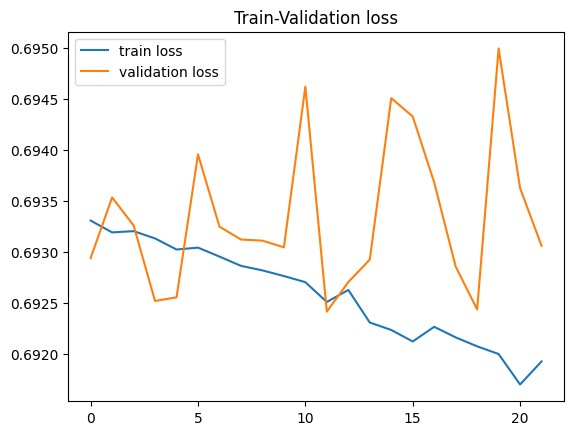

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4961734693877551, 'precision': 0.4961734693877551, 'f1': 0.4961734693877551, 'accuracy': 0.4961734693877551}
MALE {'recall': 0.2838541666666667, 'precision': 0.2838541666666667, 'f1': 0.2838541666666667, 'accuracy': 0.2838541666666667}
FEMALE {'recall': 0.7, 'precision': 0.7, 'f1': 0.7, 'accuracy': 0.7} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5176767676767676, 'precision': 0.5176767676767676, 'f1': 0.5176767676767676, 'accuracy': 0.5176767676767676}
MALE {'recall': 0.3236009732360097, 'precision': 0.3236009732360097, 'f1': 0.3236009732360097, 'accuracy': 0.3236009732360097}
FEMALE {'recall': 0.7270341207349081, 'precision': 0.7270341207349081, 'f1': 0.7270341207349081, 'accuracy': 0.7270341207349081} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5045632333767927, 'precision': 0.5045632333767927, 'f1': 0.5045632333767927, 'accuracy': 0.5045632333767927}
MALE {'recall': 0.2449494949

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933977176088074 	 Validation loss: 0.6933283189595756 	 
  1%|          | 574/57400 [00:06<09:46, 96.95it/s]
Epoch 2 	 Training loss: 0.6932736685051736 	 Validation loss: 0.6942359198958187 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:26, 99.31it/s]
Epoch 3 	 Training loss: 0.6932457250377443 	 Validation loss: 0.693416687391572 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:56, 93.39it/s]
Epoch 4 	 Training loss: 0.693161645002066 	 Validation loss: 0.6933218210430468 	 
  4%|▍         | 2296/57400 [00:25<09:21, 98.14it/s]
Epoch 5 	 Training loss: 0.6930933126381466 	 Validation loss: 0.6930473790330401 	 
  5%|▌         | 2870/57400 [00:31<09:09, 99.32it/s]
Epoch 6 	 Training loss: 0.6929611222046178 	 Validation loss: 0.6932178200301478 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:03, 99.35it/s]
Epoch 7 	 Training loss: 0.6930975690743649 	 Validation loss: 0.6926143098685701 	 
  7

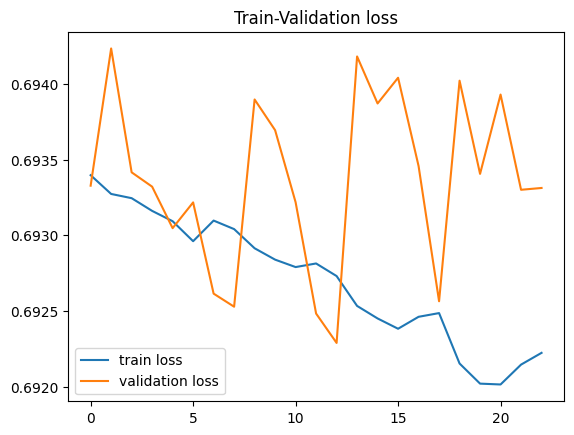

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4719387755102041, 'precision': 0.4719387755102041, 'f1': 0.4719387755102041, 'accuracy': 0.4719387755102041}
MALE {'recall': 0.2526041666666667, 'precision': 0.2526041666666667, 'f1': 0.2526041666666667, 'accuracy': 0.2526041666666667}
FEMALE {'recall': 0.6825, 'precision': 0.6825, 'f1': 0.6825, 'accuracy': 0.6825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5265151515151515, 'precision': 0.5265151515151515, 'f1': 0.5265151515151515, 'accuracy': 0.5265151515151515}
MALE {'recall': 0.2846715328467153, 'precision': 0.2846715328467153, 'f1': 0.2846715328467153, 'accuracy': 0.2846715328467153}
FEMALE {'recall': 0.7874015748031497, 'precision': 0.7874015748031497, 'f1': 0.7874015748031495, 'accuracy': 0.7874015748031497} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5267275097783573, 'precision': 0.5267275097783573, 'f1': 0.5267275097783573, 'accuracy': 0.5267275097783573}
MALE {'recall': 

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49234693877551017, 'precision': 0.49234693877551017, 'f1': 0.49234693877551017, 'accuracy': 0.49234693877551017}
Métricas etiqueta male: {'recall': 0.1857638888888889, 'precision': 0.1857638888888889, 'f1': 0.1857638888888889, 'accuracy': 0.1857638888888889}
Métricas etiqueta female:  {'recall': 0.7866666666666666, 'precision': 0.7866666666666666, 'f1': 0.7866666666666666, 'accuracy': 0.7866666666666666}

 to
Resultado global: {'recall': 0.507996632996633, 'precision': 0.507996632996633, 'f1': 0.507996632996633, 'accuracy': 0.507996632996633}
Métricas etiqueta male: {'recall': 0.20681265206812652, 'precision': 0.20681265206812652, 'f1': 0.20681265206812652, 'accuracy': 0.20681265206812652}
Métricas etiqueta female:  {'recall': 0.8328958880139983, 'precision': 0.8328958880139983, 'f1': 0.8328958880139983, 'accuracy': 0.8328958880139983}

 as
Resultado global: {'recall': 0.5058670143415906, 'precision': 0.5058670143415906, 'f1':